In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import binned_statistic
from scipy.interpolate import interp1d
from gahaco.features.feature_utils import get_data, load_positions
from gahaco.utils.tpcf import compute_tpcf
from gahaco.models import hod
from gahaco.visualization import visualize
from gahaco.utils.tpcf import compute_tpcf, compute_power_spectrum
from sklearn.metrics import confusion_matrix

from halotools.empirical_models import Zheng07Cens, Zheng07Sats
from halotools.sim_manager import UserSuppliedHaloCatalog
from halotools.empirical_models import TrivialPhaseSpace, NFWPhaseSpace, HodModelFactory

Using TensorFlow backend.
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [58]:
#TODO: fix halotools, add halo low mass cut when computing satellite best fit parameters
import seaborn as sns
sns.set_context('paper')

In [6]:

df = pd.read_hdf('/cosma7/data/dp004/dc-cues1/tng_dataframes/merged_dataframe_300.h5')
#train, test, test_pos_hydro = get_data(hdf5_filename, 'dark_or_light')


# HOD for full box

In [19]:
halo_occ = hod.HOD(df.M200_DMO.values, N_gals,
                  satellites=False)

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [40]:
np.log10(np.min(halo_occ.mass_c))

11.111689363482975

In [75]:
xvalues = np.logspace(10.7,
                      np.log10(np.max(halo_occ.mass_c)),
                      1000
                     )

In [79]:
halo_occ.hod_parameters_centrals

{'logMmin': 11.194295445851541, 'sigma_logM': 0.1830414708820544}

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


{'logMmin': 11.194295445851541, 'sigma_logM': 0.1830414708820544}
0.018041757954759798
{'logMmin': 11.46753504788262, 'sigma_logM': 0.17255939148768495}
0.010704661859230132
{'logMmin': 11.56894853614069, 'sigma_logM': 0.17279217727594018}
0.008706896301562659


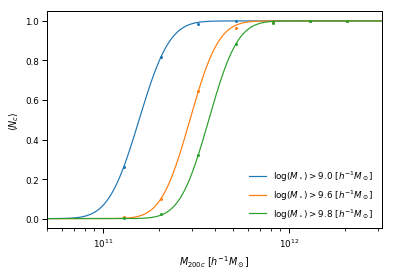

In [82]:
fig = plt.figure()
ax = plt.axes()
stellar_mass_thresholds = [9.,9.6,9.8]
for threshold in stellar_mass_thresholds:
    N_gals = df.M_stars_central > 10**threshold
    halo_occ = hod.HOD(df.M200_DMO.values, N_gals,
                  satellites=False)
    print(halo_occ.hod_parameters_centrals)
    print(np.sum(N_gals)/205**3)
    p = ax.plot(halo_occ.mass_c, halo_occ.measured_n_central,
           linestyle = '', marker = 'o', markersize=2
           #color = 'blue',
               )
                
    color = p[0].get_color()

    ax.plot(xvalues, 
            halo_occ.mean_occupation_centrals( xvalues,
                            **halo_occ.hod_parameters_centrals),
           color= color,
            label = f'$\log(M_\star) > {threshold} \\ [h^{{-1}}M_\odot]$',
            )

ax.set_xscale("log")
#ax.set_yscale("log")

ax.set_ylabel(r'$\langle N_c \rangle$')
ax.set_xlabel(r'$M_{200c}$ $[h^{-1}M_\odot]$')
ax.set_xlim(10**(10.7), 10**12.5)
plt.legend(frameon=False)
plt.savefig('../reports/figures/halo_occupation.png',
            dpi = 250,
            bbox_inches='tight'
           )

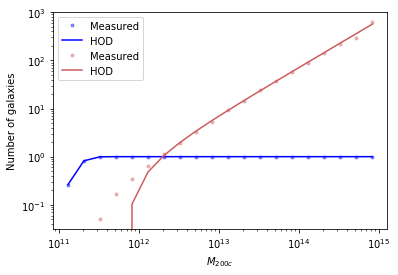

In [7]:
fig = plt.figure()
ax = plt.axes()
ax.plot(halo_occ.mass_c, halo_occ.measured_n_central,
       linestyle = '', marker = 'o', markersize = 3,
       color = 'blue', alpha = 0.4, label = 'Measured')
ax.plot(halo_occ.mass_c, halo_occ.mean_n_central,
       color= 'blue', label = 'HOD')

ax.plot(halo_occ.mass_c, halo_occ.measured_n_satellites,
       linestyle = '', marker = 'o', markersize = 3,
       color = 'indianred', alpha = 0.4, label = 'Measured')
ax.plot(halo_occ.mass_c, 
        halo_occ.mean_n_central*halo_occ.mean_n_satellites,
       color= 'indianred', label = 'HOD')
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel('Number of galaxies')
ax.set_xlabel(r'$M_{200c}$')
plt.legend()

In [8]:
halo_occ.mean_occupation_satellites(halo_occ.m200c, **halo_occ.hod_parameters_sats)

array([689.57960141, 593.6947677 , 439.33289821, ...,   0.        ,
         0.        ,   0.        ])

In [9]:
n_satellites = np.random.poisson(halo_occ.mean_occupation_satellites(halo_occ.m200c, **halo_occ.hod_parameters_sats),                 
                                                                    len(halo_occ.m200c))

In [10]:
halo_occ.hod_parameters_sats

{'logMcut': 11.840620119609508,
 'logM1': 12.109465194367196,
 'alpha': 0.9790566025315406}

In [11]:
n_centrals = halo_occ.populate_centrals()

In [12]:
n_c, n_satellites = halo_occ.populate_satellites(n_centrals)

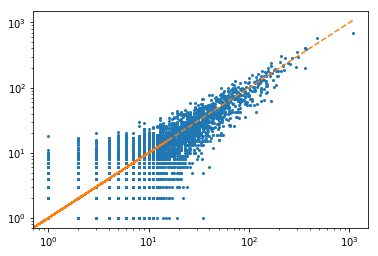

In [13]:
plt.loglog(df.N_gals-1, n_satellites, linestyle='', marker='o', markersize=2)
plt.plot(df.N_gals-1, df.N_gals-1, linestyle='--')

In [14]:
hydro_pos, dmo_pos = load_positions()


In [15]:
df.columns

Index(['ID_DMO', 'ID_HYDRO', 'M200_HYDRO', 'M200c', 'Rmax', 'R200c', 'Cnfw',
       'Rhosnfw', 'Formation Time', 'Nmergers', 'MassPeak', 'vpeak',
       'N_subhalos', 'VelDisp', 'Vmax', 'Spin', 'fsub_unbound', 'x_offset',
       'HalfmassRad', 'MassInMaxRad', 'env_5', 'env_10', 'x_dmo', 'y_dmo',
       'z_dmo', 'concentration_prada', 'concentration_nfw', 'rho_s',
       'chisq_nfw', 'vel_ani_param', 'total_M_stars', 'x_hydro', 'y_hydro',
       'z_hydro', 'N_gals', 'M_stars'],
      dtype='object')

In [16]:
sat_pos_ncfw = halo_occ.satellites_positions(dmo_pos, n_satellites,
                         df.concentration_nfw.values,
                         df.R200c.values)

In [64]:
len(sat_pos_ncfw)

108223

In [31]:
sat_pos_cnfw = halo_occ.satellites_positions(dmo_pos, n_satellites,
                         df.Cnfw.values,
                         df.R200c.values)

In [33]:
from halotools.mock_observables import tpcf

def compute_tpcf(positions: np.ndarray, boxsize: float = 302.6):
    """
    Computes the real space two point correlation function using halotools

    Args:
        postions: 3D array with the cartesian coordiantes of the tracers.
        boxsize: box size of the simulation in the same units as positions.
    """
    r = np.geomspace(0.3, 30.0, 50)
    r_c = 0.5 * (r[1:] + r[:-1])
    real_tpcf = tpcf(positions, rbins=r, period=boxsize, estimator="Landy-Szalay")
    return r_c, real_tpcf


In [34]:
r_c, hydro_tpcf = compute_tpcf(hydro_pos[df.N_gals.values > 0])

r_c, hod_tpcf = compute_tpcf(dmo_pos[n_centrals > 0.])


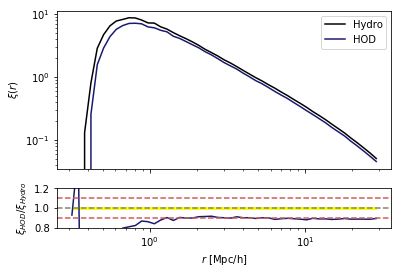

In [35]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex = True,
              gridspec_kw = {'height_ratios':[4,1]})


axes[0].loglog(r_c, hydro_tpcf, label = 'Hydro', color = 'black')
axes[0].loglog(r_c, hod_tpcf, label = 'HOD', color = 'midnightblue')
axes[1].semilogx(r_c, hod_tpcf/hydro_tpcf, color = 'midnightblue')

axes[1].axhline(y = 1., color='gray', linestyle='dashed')
axes[1].axhline(y = 1.1, color='indianred', linestyle='dashed')
axes[1].axhline(y = 0.9, color='indianred', linestyle='dashed')
axes[1].fill_between(x = r_c, y1 = 0.99, y2 = 1.01, color = 'yellow')
axes[1].set_ylim(0.8,1.2)
axes[0].set_ylabel(r'${\xi}(r)$')
axes[1].set_ylabel(r'${\xi}_{HOD}/\xi_{Hydro}$')

axes[1].set_xlabel(r'$r$ [Mpc/h]')
axes[0].legend()

In [55]:
# Correlation function with satellites
path = '/cosma6/data/dp004/dc-cues1/tng_dataframes/'
all_gals_pos = np.load(path + 'galaxy_positions.npy')
r_c, all_hydro_tpcf = compute_tpcf(all_gals_pos/1000.)


In [43]:
all_hod_pos = np.concatenate((dmo_pos[n_centrals > 0.], sat_pos_ncfw))
r_c, all_hod_tpcf = compute_tpcf(all_hod_pos)


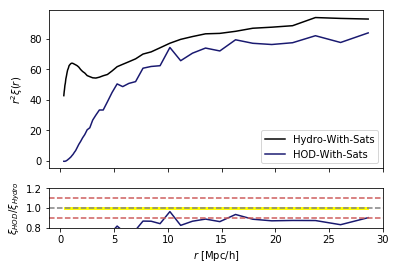

In [68]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex = True,
              gridspec_kw = {'height_ratios':[4,1]})

axes[0].plot(r_c, r_c**2*all_hydro_tpcf, label = 'Hydro-With-Sats', color = 'black')
axes[0].plot(r_c, r_c**2*all_hod_tpcf, label = 'HOD-With-Sats', color = 'midnightblue')
axes[1].plot(r_c, all_hod_tpcf/all_hydro_tpcf, color = 'midnightblue')

axes[1].axhline(y = 1., color='gray', linestyle='dashed')
axes[1].axhline(y = 1.1, color='indianred', linestyle='dashed')
axes[1].axhline(y = 0.9, color='indianred', linestyle='dashed')
axes[1].fill_between(x = r_c, y1 = 0.99, y2 = 1.01, color = 'yellow')
axes[1].set_ylim(0.8,1.2)
axes[0].set_ylabel(r'${r^2\xi}(r)$')
axes[1].set_ylabel(r'${\xi}_{HOD}/\xi_{Hydro}$')

axes[1].set_xlabel(r'$r$ [Mpc/h]')
axes[0].legend()

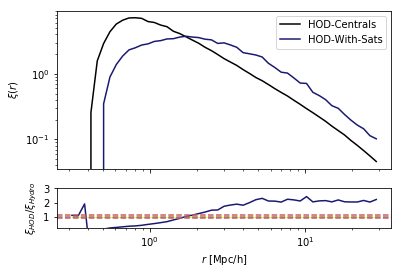

In [47]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex = True,
              gridspec_kw = {'height_ratios':[4,1]})


axes[0].loglog(r_c, hod_tpcf, label = 'HOD-Centrals', color = 'black')
axes[0].loglog(r_c, all_hod_tpcf, label = 'HOD-With-Sats', color = 'midnightblue')
axes[1].semilogx(r_c, all_hod_tpcf/hod_tpcf, color = 'midnightblue')

axes[1].axhline(y = 1., color='gray', linestyle='dashed')
axes[1].axhline(y = 1.1, color='indianred', linestyle='dashed')
axes[1].axhline(y = 0.9, color='indianred', linestyle='dashed')
axes[1].fill_between(x = r_c, y1 = 0.99, y2 = 1.01, color = 'yellow')
axes[1].set_ylim(0.2,3)
axes[0].set_ylabel(r'${\xi}(r)$')
axes[1].set_ylabel(r'${\xi}_{HOD}/\xi_{Hydro}$')

axes[1].set_xlabel(r'$r$ [Mpc/h]')
axes[0].legend()

In [19]:
halo_occ.hod_parameters_sats

{'logMcut': 11.840620119609508,
 'logM1': 12.109465194367196,
 'alpha': 0.9790566025315406}

In [67]:
velocities = np.zeros((len(df), 3)) + 2

In [68]:
boxsize=303

In [136]:
halocat = UserSuppliedHaloCatalog( redshift = 0., Lbox = boxsize, 
        halo_x =df.x_dmo.values.clip(0), halo_y = df.y_dmo.values, halo_z = df.z_dmo.values,
        halo_vx = velocities[:,0], halo_vy = velocities[:,1], halo_vz = velocities[:,2],
        halo_mvir = 10**df.M200c.values, halo_id = df.ID_DMO.values, halo_hostid = df.ID_DMO.values,
        particle_mass = 1e9, halo_upid = -1. * np.ones_like(df.ID_DMO.values),
        halo_rvir = df.R200c.values
        )

In [128]:
cens_prof_model = TrivialPhaseSpace()

In [129]:
model_instance = HodModelFactory(
    centrals_occupation = cen_model,
    centrals_profile = cens_prof_model)

In [130]:
model_instance.populate_mock(halocat)

In [145]:
df_mock_test = pd.DataFrame(np.array(model_instance.mock.galaxy_table))

In [146]:
pos_test_mock = np.vstack([df_mock_test['x'], 
                           df_mock_test['y'],
                           df_mock_test['z']]
                         ).T

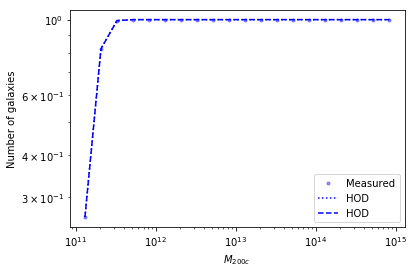

In [147]:
fig = plt.figure()
ax = plt.axes()
ax.plot(halo_occ.mass_c, halo_occ.measured_n_central,
       linestyle = '', marker = 'o', markersize = 3,
       color = 'blue', alpha = 0.4, label = 'Measured')
ax.plot(halo_occ.mass_c, halo_occ.mean_n_central,
       color= 'blue', label = 'HOD', linestyle='dotted')

ax.plot(halo_occ.mass_c, model_instance.mean_occupation_centrals(prim_haloprop = halo_occ.mass_c),
       color= 'blue', label = 'HOD', linestyle='dashed')

#ax.plot(halo_occ.mass_c, halo_occ.measured_n_satellites,
#       linestyle = '', marker = 'o', markersize = 3,
#       color = 'indianred', alpha = 0.4, label = 'Measured')
#ax.plot(halo_occ.mass_c, 
#        halo_occ.mean_n_central*halo_occ.mean_n_satellites,
#       color= 'indianred', label = 'HOD')
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel('Number of galaxies')
ax.set_xlabel(r'$M_{200c}$')
plt.legend()

In [148]:
pos_test_mock.shape

(84733, 3)

In [149]:
dmo_pos[n_centrals > 0.].shape

(153665, 3)

In [150]:
r_c, mock_tpcf = compute_tpcf(pos_test_mock)

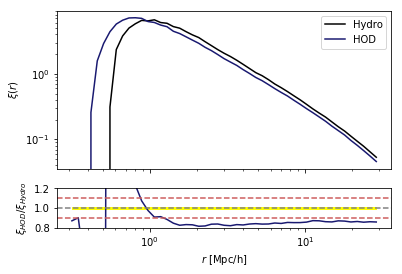

In [151]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex = True,
              gridspec_kw = {'height_ratios':[4,1]})


axes[0].loglog(r_c, mock_tpcf, label = 'Hydro', color = 'black')
axes[0].loglog(r_c, hod_tpcf, label = 'HOD', color = 'midnightblue')
axes[1].semilogx(r_c, hod_tpcf/mock_tpcf, color = 'midnightblue')

axes[1].axhline(y = 1., color='gray', linestyle='dashed')
axes[1].axhline(y = 1.1, color='indianred', linestyle='dashed')
axes[1].axhline(y = 0.9, color='indianred', linestyle='dashed')
axes[1].fill_between(x = r_c, y1 = 0.99, y2 = 1.01, color = 'yellow')
axes[1].set_ylim(0.8,1.2)
axes[0].set_ylabel(r'${\xi}(r)$')
axes[1].set_ylabel(r'${\xi}_{HOD}/\xi_{Hydro}$')

axes[1].set_xlabel(r'$r$ [Mpc/h]')
axes[0].legend()